In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

train = pd.read_csv("C:\\Users\\user\\AnacondaProjects\\Sberbank\\train.csv", parse_dates=['timestamp'])
test =  pd.read_csv("C:\\Users\\user\\AnacondaProjects\\Sberbank\\test.csv", parse_dates=['timestamp'])
macro = pd.read_csv("C:\\Users\\user\\AnacondaProjects\\Sberbank\\macro.csv", parse_dates=['timestamp'])

#selecting only important macro columns
#macro = macro[["timestamp","balance_trade","balance_trade_growth","eurrub","average_provision_of_build_contract","micex_rgbi_tr","micex_cbi_tr","deposits_rate","mortgage_value","mortgage_rate","income_per_cap","rent_price_4+room_bus","museum_visitis_per_100_cap","apartment_build"]]

y_train = train['price_doc']
id_test = test['id']

train.drop(['id', 'price_doc'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

# Build all_data = (train+test).join(macro)
num_train = len(train)
all_data = pd.concat([train, test])
all_data = all_data.join(macro, on='timestamp', rsuffix='_macro')

'''
# Add month-year
month_year = (all_data.timestamp.dt.month + all_data.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
all_data['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (all_data.timestamp.dt.weekofyear + all_data.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
all_data['week_year_cnt'] = week_year.map(week_year_cnt_map)
'''

# Creating Apartment Name Feature
all_data['apartment_name'] = pd.factorize(all_data.sub_area + all_data['metro_km_avto'].astype(str))[0]

#cleaning of full_sq
all_data.loc[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data["life_sq"]>=6) & (all_data["life_sq"]<300) & ((all_data["full_sq"]>= all_data["life_sq"]*15) | ((all_data["full_sq"]>=0) & (all_data["full_sq"]<all_data["life_sq"]))),"full_sq"]=all_data[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data["life_sq"]>=6) & (all_data["life_sq"]<300) & ((all_data["full_sq"]>= all_data["life_sq"]*15) | ((all_data["full_sq"]>=0) & (all_data["full_sq"]<all_data["life_sq"])))].life_sq
g_Apartment_col=all_data.groupby('apartment_name')['full_sq'].agg(['mean','median','count']).reset_index()
g_Apartment_col.columns= ['apartment_name','full_sq_mean','full_sq_median','apartment_count'] 
all_data=all_data.merge(g_Apartment_col, how='left')
all_data.loc[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data.apartment_count>3),"full_sq"]=all_data[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data.apartment_count>3)].full_sq_mean

all_data.drop("full_sq_median", axis=1, inplace=True)
all_data.drop("full_sq_mean", axis=1, inplace=True)

# Remove timestamp column (may overfit the model in train)
all_data.drop(['timestamp', 'timestamp_macro'], axis=1, inplace=True)

# cleaning price_doc
train = all_data[:num_train]
test  = all_data[num_train:]

train = pd.concat((train,y_train),axis=1)
train["prize_per_sqrmtr"]=train.price_doc/train.full_sq

# grouping by price_doc
g_Apartment_col=train.groupby('apartment_name')['prize_per_sqrmtr'].agg(['mean','std']).reset_index()
g_Apartment_col.columns= ['apartment_name','pps_mean','pps_std'] 
train=train.merge(g_Apartment_col, how='left')
# change value if more than 4 sigma
train.loc[(train.prize_per_sqrmtr > train.pps_mean + (4*train.pps_std)) | (train.prize_per_sqrmtr < train.pps_mean - (4*train.pps_std)),"prize_per_sqrmtr"]=train[(train.prize_per_sqrmtr > train.pps_mean + (4*train.pps_std)) | (train.prize_per_sqrmtr < train.pps_mean - (4*train.pps_std))].pps_mean
# grouping by sub_area
g_Apartment_col=train.groupby('sub_area')['prize_per_sqrmtr'].agg(['mean']).reset_index()
g_Apartment_col.columns= ['sub_area','sa_mean'] 
train=pd.merge(train, g_Apartment_col, how='left', on='sub_area')
# Change if out of range
train.loc[ (train.prize_per_sqrmtr>=600000) | (train.prize_per_sqrmtr<=10000),"prize_per_sqrmtr"]= train[(train.prize_per_sqrmtr>=600000) | (train.prize_per_sqrmtr<=18418)].sa_mean
train["price_doc"]=train.prize_per_sqrmtr*train.full_sq
y_train = train['price_doc'].values
# Dropping grouping columns
train.drop(['pps_mean','pps_std','sa_mean','prize_per_sqrmtr','price_doc'], axis=1, inplace=True)

all_data = pd.concat([train, test])

# cleaning life_sq
all_data.loc[(all_data.life_sq.isnull()) | (all_data.life_sq<6) | (all_data.life_sq>all_data.full_sq) | (all_data.life_sq>224),"life_sq"] =all_data[(all_data.life_sq.isnull()) | (all_data.life_sq<6) | (all_data.life_sq>all_data.full_sq) | (all_data.life_sq>224)].full_sq/1.66

# cleaning floor
all_data.loc[(all_data.floor>48),"floor"]=np.NaN

# cleaning max_floor
g_Apartment_col=all_data.groupby('apartment_name')['floor'].agg(['max']).reset_index()
g_Apartment_col.columns= ['apartment_name','apartment_floor_max'] 
all_data=all_data.merge(g_Apartment_col, how='left')
all_data.loc[((all_data.max_floor.isnull()) | (all_data.max_floor>48)) & (all_data.apartment_count>3),"max_floor"] = all_data[((all_data.max_floor.isnull()) | (all_data.max_floor>48)) & (all_data.apartment_count>3)].apartment_floor_max
all_data.drop(['apartment_floor_max'], axis=1, inplace=True)
all_data.loc[((all_data.max_floor.isnull()) | (all_data.floor>0)),"max_floor"]=all_data[(all_data.max_floor.isnull()) | (all_data.floor>0)].floor+1

# cleaning build_year
g_Apartment_col=all_data.groupby('apartment_name')['build_year'].agg(['median']).reset_index()
g_Apartment_col.columns= ['apartment_name','byear_mean']
all_data=pd.merge(all_data, g_Apartment_col, how='left', on='apartment_name')
all_data.loc[(all_data.build_year<1950) | (all_data.build_year>2020) , "build_year"]=all_data[(all_data.build_year<1950) | (all_data.build_year>2020)].byear_mean
all_data.drop(['byear_mean'], axis=1, inplace=True)

# cleaning num_room
g_Apartment_col=all_data.groupby('apartment_name')['num_room'].agg(['median']).reset_index()
g_Apartment_col.columns= ['apartment_name','nrmedian']
all_data=pd.merge(all_data, g_Apartment_col, how='left', on='apartment_name')
all_data.loc[((all_data.num_room>=7) & (all_data.full_sq<100)) | (all_data.num_room==0) | (all_data.num_room.isnull()),"num_room"]=all_data[((all_data.num_room>=7) & (all_data.full_sq<100)) | (all_data.num_room==0) | (all_data.num_room.isnull())].nrmedian
all_data.drop(['nrmedian'], axis=1, inplace=True)

all_data['rel_kitch_sq'] = all_data['kitch_sq'] / all_data['life_sq'].astype(float)


# cleaning kitch_sq
g_Apartment_col=all_data.groupby('apartment_name')['rel_kitch_sq'].agg(['median']).reset_index()
g_Apartment_col.columns= ['apartment_name','rksmedian']
all_data=pd.merge(all_data, g_Apartment_col, how='left', on='apartment_name')
all_data.loc[((all_data.rel_kitch_sq>1) | (all_data.kitch_sq==0) |(all_data.kitch_sq>60) | (all_data.kitch_sq.isnull())) & (all_data.apartment_count>=5),"kitch_sq" ]=all_data[((all_data.rel_kitch_sq>1) | (all_data.kitch_sq==0) |(all_data.kitch_sq>60) | (all_data.kitch_sq.isnull())) & (all_data.apartment_count>=5)].life_sq * all_data[((all_data.rel_kitch_sq>1) | (all_data.kitch_sq==0) |(all_data.kitch_sq>60) | (all_data.kitch_sq.isnull())) & (all_data.apartment_count>=5)].rksmedian
all_data.loc[(all_data.rel_kitch_sq>1) | (all_data.kitch_sq==0) |(all_data.kitch_sq>60) | (all_data.kitch_sq.isnull()),"kitch_sq"]=all_data[(all_data.rel_kitch_sq>1) | (all_data.kitch_sq==0) |(all_data.kitch_sq>60) | (all_data.kitch_sq.isnull())].life_sq * 0.23
all_data.drop(['rksmedian'], axis=1, inplace=True)


# cleaning state
g_Apartment_col=all_data[all_data.state>=0].groupby('apartment_name')['state'].agg(['median','mean']).reset_index()
g_Apartment_col.columns= ['apartment_name','state_median','state_mean']
all_data=pd.merge(all_data, g_Apartment_col, how='left', on='apartment_name')
all_data.loc[((all_data.state.isnull())|(all_data.state>4))&(all_data.apartment_count>=5)&(all_data.state_median>=0) ,"state"]=all_data[((all_data.state.isnull())|(all_data.state>4))&(all_data.apartment_count>=5) & (all_data.state_median>=0)].state_median.astype(int)
all_data.drop(['state_median'], axis=1, inplace=True)
all_data.drop(['state_mean'], axis=1, inplace=True)


# cleaning material
g_Apartment_col=all_data[all_data.material>=0].groupby('apartment_name')['material'].agg(['median','mean']).reset_index()
g_Apartment_col.columns= ['apartment_name','mat_median','mat_mean']
all_data=pd.merge(all_data, g_Apartment_col, how='left', on='apartment_name')
all_data.loc[((all_data.material.isnull())|(all_data.material>6))&(all_data.apartment_count>=5)&(all_data.mat_median>=0) ,"material"]=all_data[((all_data.material.isnull())|(all_data.material>6))&(all_data.apartment_count>=5) & (all_data.mat_median>=0)].mat_median.astype(int)
all_data.drop(['mat_median'], axis=1, inplace=True)
all_data.drop(['mat_mean'], axis=1, inplace=True)
all_data.drop(['apartment_name'], axis=1, inplace=True)

all_data['rel_floor'] = all_data['floor'] / all_data['max_floor'].astype(float)
all_data['rel_kitch_sq'] = all_data['kitch_sq'] / all_data['full_sq'].astype(float)


factorize = lambda t: pd.factorize(t[1])[0]

df_obj = all_data.select_dtypes(include=['object'])

X_all = np.c_[
    all_data.select_dtypes(exclude=['object']).values,
    np.array(list(map(factorize, df_obj.iteritems()))).T
]

X_train = X_all[:num_train]
X_test = X_all[num_train:]



# Deal with categorical values
df_numeric = all_data.select_dtypes(exclude=['object'])
df_obj = all_data.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

X_train = X_all[:num_train]
X_test = X_all[num_train:]

df_columns = df_values.columns

(38133, 391)


In [2]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3
}

dtrain = xgb.DMatrix(X_train, y_train, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)

cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=20, show_stdv=False)

[0]	train-rmse:8.18756e+06	test-rmse:8.19445e+06
[20]	train-rmse:3.8024e+06	test-rmse:3.99634e+06
[40]	train-rmse:2.51134e+06	test-rmse:2.91066e+06
[60]	train-rmse:2.15374e+06	test-rmse:2.6735e+06
[80]	train-rmse:2.02126e+06	test-rmse:2.60794e+06
[100]	train-rmse:1.94738e+06	test-rmse:2.57983e+06
[120]	train-rmse:1.89019e+06	test-rmse:2.56126e+06
[140]	train-rmse:1.84632e+06	test-rmse:2.54979e+06
[160]	train-rmse:1.8098e+06	test-rmse:2.54402e+06
[180]	train-rmse:1.76677e+06	test-rmse:2.53765e+06
[200]	train-rmse:1.73444e+06	test-rmse:2.53262e+06
[220]	train-rmse:1.70345e+06	test-rmse:2.52881e+06
[240]	train-rmse:1.67092e+06	test-rmse:2.52532e+06
[260]	train-rmse:1.64341e+06	test-rmse:2.52428e+06
[280]	train-rmse:1.61781e+06	test-rmse:2.52315e+06
[300]	train-rmse:1.58963e+06	test-rmse:2.52124e+06
[320]	train-rmse:1.563e+06	test-rmse:2.5202e+06
[340]	train-rmse:1.53812e+06	test-rmse:2.52067e+06


In [3]:
%matplotlib inline

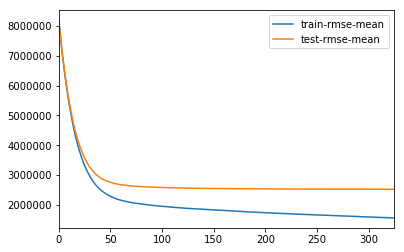

In [4]:
num_boost_rounds = len(cv_result)
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()

In [5]:
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

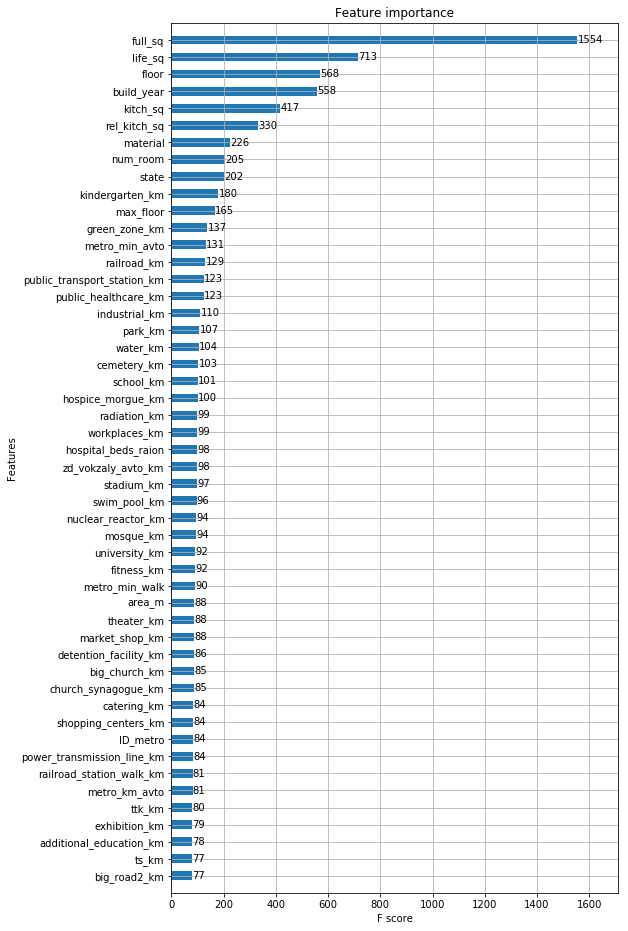

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [7]:
x_pred = model.predict(dtrain)

In [8]:
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

In [9]:
rmsle(x_pred,y_train)

0.41033374691471286

In [10]:
y_pred = model.predict(dtest)

df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

df_sub.to_csv('subxgb.csv', index=False)

In [11]:
x_pred

array([  5737350.5,   5791184.5,   5196640. , ...,   5433015.5,
        11578015. ,   5741001.5], dtype=float32)

In [12]:
type(x_pred)

numpy.ndarray

In [13]:
train_pred = pd.DataFrame(data=x_pred)

In [14]:
y_train[7]

2000000.0

In [15]:
import seaborn as sns

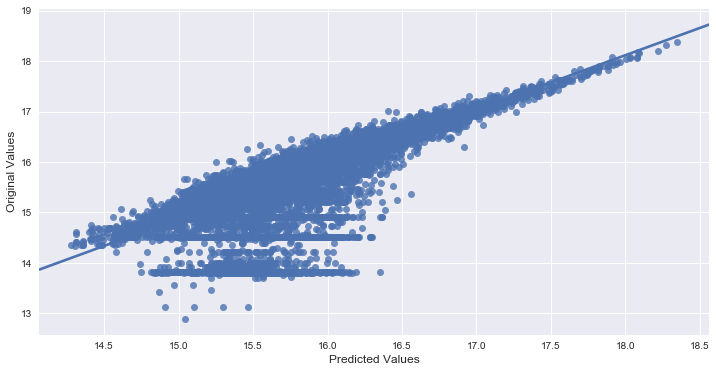

In [16]:
plt.figure(figsize=(12,6))
sns.regplot(x=(np.log1p(train_pred[0])) ,y=np.log1p(y_train))
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Original Values', fontsize=12)
plt.show()

In [17]:
df_y_train = pd.DataFrame(data=y_train)

In [18]:
df_y_train[np.log1p(df_y_train[0])<13.5]

,0
96,500000.0
743,500000.0
1149,500000.0
2540,705805.0
2748,395685.0
2778,675205.0
25695,500000.0


In [19]:
train_pred[0][97]

5279043.5

In [20]:
train[:100].tail(5)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm,apartment_name,apartment_count
95,54.0,37.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93,1
96,30.0,18.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94,1
97,39.0,18.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95,1
98,51.0,30.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96,2
99,74.0,45.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97,1
